# GeoPandas: Pandas + geometry data type + custom geo goodness
[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2018-9-9

## 1. Background

[GeoPandas](http://geopandas.org) adds a spatial geometry data type to `Pandas` and enables spatial operations on these types, using [shapely](http://toblerity.org/shapely/). GeoPandas leverages Pandas together with several core open source geospatial packages and practices to provide a uniquely simple and convenient framework for handling geospatial feature data, operating on both geometries and attributes jointly, and as with Pandas, largely eliminating the need to iterate over features (rows). Also as with Pandas, it adds a very convenient and fine-tuned plotting method, and read/write methods that handle multiple file and "serialization" formats.

**_NOTES:_**
- Like `shapely`, these spatial data types are limited to discrete entities/features and do not address continuously varying rasters or fields.
- While GeoPandas spatial objects can be assigned a Coordinate Reference System (`CRS`), operations can not be performed across CRS's. Plus, geodetic ("unprojected", lat-lon) CRS are not handled in a special way; the area of a geodetic polygon will be in degrees.

GeoPandas builds on mature, stable and widely used packages (Pandas, shapely, etc). It is being supported more and more as a preferred Python data structure for geospatial vector data.

**When should you use GeoPandas?**
- For exploratory data analysis, including in Jupyter notebooks.
- For highly compact and readable code. Which in turn improves reproducibility.
- If you're comfortable with Pandas, R dataframes, or tabular/relational approaches.

**When it may not be the best tool?**
- For polished map creation and multi-layer, interactive visualization; if you're comfortable with GIS software, one option is to use a desktop GIS like QGIS! You can generate intermediate GIS files and plots with GeoPandas, then shift over to QGIS. Or refine the plots in Python with matplotlib or additional packages. GeoPandas can help you manage and pre-process the data, and do initial visualizations.
- If you need very high performance, though I'm not sure about current limitations. Performance has been increasing and substantial enhancements are in the works (including possibly a [Dask](http://dask.pydata.org) parallelization implementation).

## 2. Set up packages and data file path
We'll use these throughout the rest of the tutorial.

In [3]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

data_pth = "../data"

In [5]:
# view library versions
mpl.__version__, pd.__version__, gpd.__version__

('2.2.2', '0.23.4', '0.4.0')

## 3. GeoSeries: The geometry building block

Like a Pandas `Series`, a `GeoSeries` is the building block for the more broadly useful and powerful `GeoDataFrame` that we'll focus on in this tutorial. Here we'll first take a bit of time to examine a `GeoSeries`.

A `GeoSeries` is made up of an index and a GeoPandas `geometry` data type. This data type is a [shapely.geometry object](http://toblerity.org/shapely/manual.html#geometric-objects), and therefore inherits their attributes and methods such as `area`, `bounds`, `distance`, etc.

GeoPandas has six classes of **geometric objects**, corresponding to the three basic single-entity geometric types and their associated homogeneous collections of multiple entities:
- **Single entity (core, basic types):**
  - Point
  - Line (*formally known as a LineString*)
  - Polygon
- **Homogeneous entity collections:**
  - Multi-Point
  - Multi-Line (*MultiLineString*)
  - Multi-Polygon

A `GeoSeries` is then a list of geometry objects and their associated index values.

**_NOTE/WATCH:_**   
Entries (rows) in a GeoSeries can store different geometry types; GeoPandas does not constrain the geometry column to be of the same geometry type. This can lead to unexpected problems if you're not careful! Specially if you're used to thinking of a GIS file format like shape files, which store a single geometry type. Also beware that certain export operations (say, to shape files ...) will fail if the list of geometry objects is heterogeneous.

But enough theory! Let's get our hands dirty (so to speak) with code. We'll start by illustrating how GeoSeries are constructured.

### Create a `GeoSeries` from a list of `shapely Point` objects constructed directly from `WKT` text
**Though you will rarely need this raw approach!**

In [7]:
from shapely.wkt import loads
#                 POINT(x y)           POINT( x   y )           POINT(x y)
GeoSeries([loads('POINT(1 2)'), loads('POINT(1.5 2.5)'), loads('POINT(2 3)')])

0        POINT (1 2)
1    POINT (1.5 2.5)
2        POINT (2 3)
dtype: object

### Create a `GeoSeries` from a list of `shapely Point` objects using the `Point` constructor

In [9]:
# passing values to Point() (makes more sense than specifying the strings above)
gs = GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
gs

0        POINT (-120 45)
1      POINT (-121.2 46)
2    POINT (-122.9 47.5)
dtype: object

In [10]:
type(gs), len(gs)

(geopandas.geoseries.GeoSeries, 3)

A GeoSeries (and a GeoDataFrame) can store a CRS implicitly associated with the geometry column. This is useful as essential spatial metadata and for transformation (reprojection) to another CRS. Let's assign the CRS.

In [12]:
# EPSG:4326 (lat, lon)
gs.crs = {'init': 'epsg:4326'}

The `plot` method accepts standard `matplotlib.pyplot` style options, and can be tweaked like any other `matplotlib` figure.

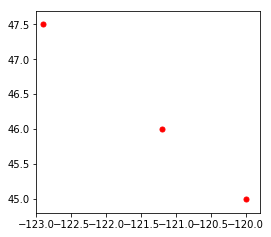

In [18]:
gs.plot(marker='.', color='red', markersize=100, figsize=(4, 4))
plt.xlim([-123, -119.8])
plt.ylim([44.8, 47.7]);

**Let's get a bit fancier, as a stepping stone to GeoDataFrames.** First, we'll define a simple dictionary of lists, that we'll use again later.

In [19]:
data = {'name': ['a', 'b', 'c'],
        'lat': [45, 46, 47.5],
        'lon': [-120, -121.2, -122.9]}

Note this convenient, compact approach to create a list of `Point` shapely objects out of X & Y coordinate lists (an alternate approach is shown in the Advanced notebook):

In [21]:
# use the above dictionary to create geometry
geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
geometry

We'll wrap up by creating a GeoSeries where we explicitly define the index values.

In [22]:
gs = GeoSeries(geometry, index=data['name'])
gs

a        POINT (-120 45)
b      POINT (-121.2 46)
c    POINT (-122.9 47.5)
dtype: object

## 4. GeoDataFrames: The real power tool

**_NOTE/HIGHLIGHT:_**   
- It's worth noting that a GeoDataFrame can be described as a *Feature Collection*, where each row is a *Feature*, a *geometry* column is defined (thought the name of the column doesn't have to be "geometry"), and the attribute *Properties* includes the other columns (the Pandas DataFrame part, if you will).
- More than one column can store geometry objects! We won't explore this capability in this tutorial.

### Start with a simple, manually constructed illustration

We'll build on the GeoSeries examples. Let's reuse the `data` dictionary we defined earlier, this time to create a DataFrame.

In [24]:
# create a data frame from the dictionary above
df = pd.DataFrame(data)
df

,name,lat,lon
0,a,45.0,-120.0
1,b,46.0,-121.2
2,c,47.5,-122.9


Now we use the DataFrame and the "list-of-shapely-Point-objects" approach to create a GeoDataFrame. Note the use of two DataFrame attribute columns, which are effectively just two simple Pandas Series.

In [25]:
# use the above dataframe to create geometry
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)

There's nothing new to visualize, but this time we're using the `plot` method from a GeoDataFrame, *not* from a GeoSeries. They're not exactly the same thing under the hood.

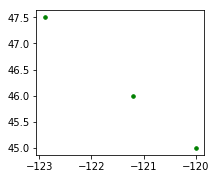

In [27]:
gdf.plot(marker='.', color='green', markersize=50, figsize=(3, 3));

### FINALLY, we get to work with real data! Load and examine the simple "oceans" shape file

`gpd.read_file` is the workhorse for reading GIS files. It leverages the [fiona](http://toblerity.org/fiona/README.html) package.

In [32]:
oceans = gpd.read_file(os.path.join(data_pth, "oceans.shp"))

In [33]:
oceans.head()

,my_polygon,ID,Oceans,geometry
0,S.Atlantic,1,South Atlantic Ocean,POLYGON ((-67.26025728926088 -59.9309210526315...
1,N.Pacific,0,North Pacific Ocean,"(POLYGON ((180 66.27034771241199, 180 0, 101.1..."
2,Southern,3,Southern Ocean,"POLYGON ((180 -60, 180 -90, -180 -90, -180 -60..."
3,Arctic,2,Arctic Ocean,POLYGON ((-100.1196521436255 52.89103112710165...
4,Indian,5,Indian Ocean,POLYGON ((19.69705552221351 -59.94160091330382...


The `crs` was read from the shape file's `prj` file:

In [34]:
oceans.crs

{'init': 'epsg:4326'}

Now we finally plot a real map (or blobs, depending on your aesthetics), from a dataset that's global-scale and stored in "geographic" (latitude & longitude) coordinates. It's *not* the actual ocean shapes defined by coastal boundaries, but bear with me. A colormap has been applied to distinguish the different Oceans.

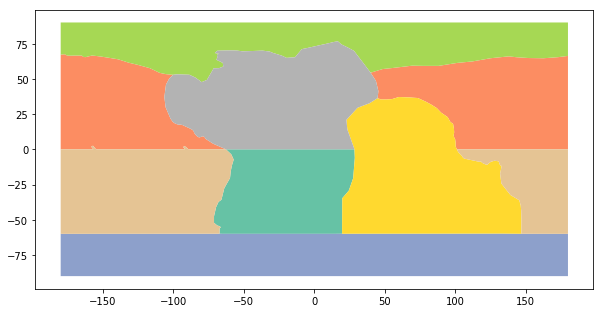

In [35]:
oceans.plot(cmap='Set2', figsize=(10, 10));

`oceans.shp` stores both `Polygon` and `Multi-Polygon` geometry types (a `Polygon` may also be viewed as a `Multi-Polygon` with 1 member). We can get at the geometry types and other geometry properties easily.

In [36]:
oceans.geom_type

0         Polygon
1    MultiPolygon
2         Polygon
3         Polygon
4         Polygon
5    MultiPolygon
6         Polygon
dtype: object

In [37]:
# Beware that these area calculations are in degrees, which is fairly useless
oceans.geometry.area

0     5287.751094
1    11805.894558
2    10822.509589
3     9578.786157
4     9047.879388
5     9640.457926
6     8616.721287
dtype: float64

In [38]:
oceans.geometry.bounds

,minx,miny,maxx,maxy
0,-71.183612,-60.000000,28.736134,0.000000
1,-180.000000,0.000000,180.000000,67.479386
2,-180.000000,-90.000000,180.000000,-59.806846
3,-180.000000,47.660532,180.000000,90.000000
4,19.697056,-59.945004,146.991853,37.102940
5,-180.000000,-60.000000,180.000000,2.473291
6,-106.430148,0.000000,45.468236,76.644442


The `envelope` method returns the bounding box for each polygon. This could be used to create a new spatial column or GeoSeries; directly for plotting; etc.

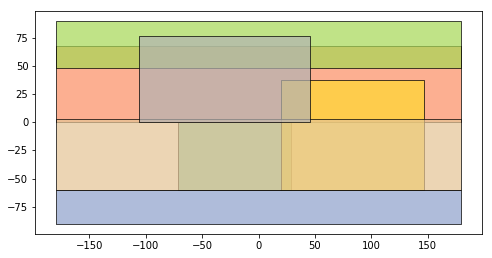

In [39]:
oceans.envelope.plot(cmap='Set2', figsize=(8, 8), alpha=0.7, edgecolor='black');

Does it seem weird that some envelope bounding boxes, such as the North Pacific Ocean, span all longitudes? That's because they're Multi-Polygons with edges at the ends of the -180 and +180 degree coordinate range.

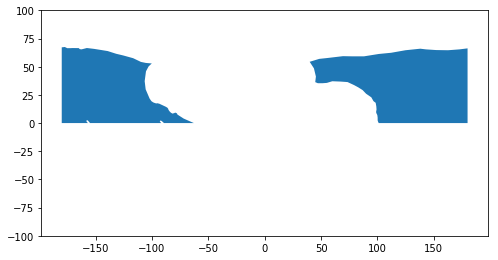

In [43]:
oceans[oceans['Oceans'] == 'North Pacific Ocean'].plot(figsize=(8, 8));
plt.ylim([-100, 100]);

### Load "Natural Earth" countries dataset, bundled with GeoPandas
*"[Natural Earth](http://www.naturalearthdata.com) is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software."* A subset comes bundled with GeoPandas and is accessible from the `gpd.datasets` module. We'll use it as a helpful global base layer map.

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...


Its CRS is also EPSG:4326:

In [45]:
world.crs

{'init': 'epsg:4326'}

In [60]:
world.geom_type

0           Polygon
1      MultiPolygon
2           Polygon
3           Polygon
4      MultiPolygon
5           Polygon
6      MultiPolygon
7           Polygon
8      MultiPolygon
9           Polygon
10     MultiPolygon
11          Polygon
12          Polygon
13          Polygon
14          Polygon
15          Polygon
16          Polygon
17     MultiPolygon
18          Polygon
19          Polygon
20          Polygon
21          Polygon
22          Polygon
23          Polygon
24          Polygon
25          Polygon
26          Polygon
27     MultiPolygon
28          Polygon
29     MultiPolygon
           ...     
147         Polygon
148         Polygon
149         Polygon
150         Polygon
151         Polygon
152         Polygon
153         Polygon
154         Polygon
155         Polygon
156         Polygon
157         Polygon
158         Polygon
159         Polygon
160         Polygon
161         Polygon
162    MultiPolygon
163         Polygon
164         Polygon
165         Polygon


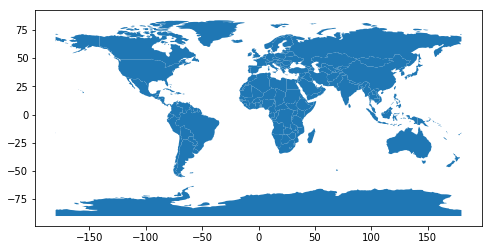

In [61]:
# GeoDataFrame.plot
world.plot(figsize=(8, 8));

### Map plot overlays: Plotting multiple spatial layers

Here's a compact, quick way of using the GeoDataFrame plot method to overlay two GeoDataFrames while style customizing the styles for each layer.

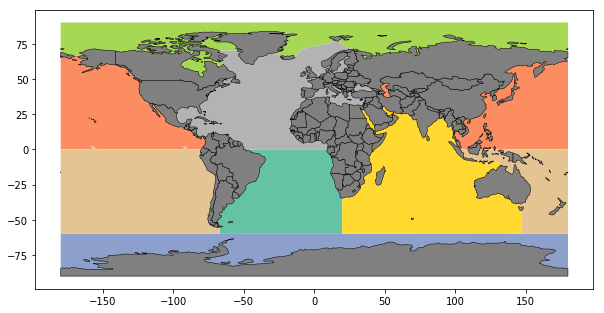

In [68]:
# gdf.plot(gdf.plot())
# plotted in front ( plotted in back )
world.plot(ax=oceans.plot(cmap='Set2', figsize=(10, 10)), facecolor='grey',edgecolor='k',linewidth=.5);

We can also compose the plot using conventional `matplotlib` steps and options that give us more control.

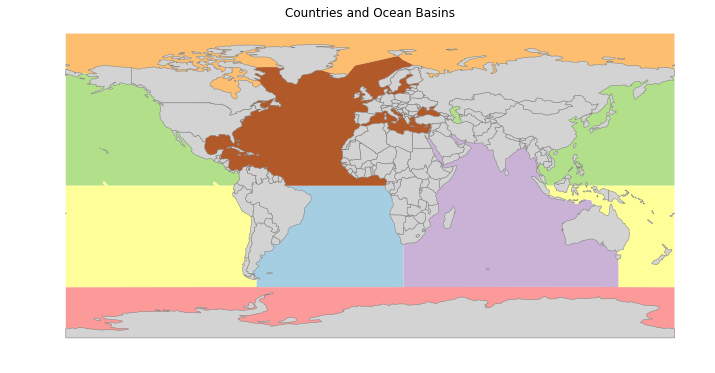

In [70]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Countries and Ocean Basins')
# Other nice categorical color maps (cmap) include 'Set2' and 'Set3'
oceans.plot(ax=ax, cmap='Paired')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray',linewidth=0.5)
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

**_NOTE/FUN:_**  
Let's stop for a bit to explore on your own, hack with your neighbors, ask questions.

## 5. Extras: Reading from other data source types; fancier plotting
- Read from remote PostgreSQL/PostGIS database.
- Read from a remote OGC WFS service.

### Read PostgreSQL/PostGIS dataset from the Amazon Cloud
The fact that it's on an Amazon Cloud is irrelevant. The approach is independent of the location of the database server; it could be on your computer.

In [71]:
import json
import psycopg2

First we'll read the database connection information from a hidden JSON file, to add a level of security and not expose all that information on the github GeoHackWeek repository. This is also a good practice for handling sensitive information.

In [72]:
with open(os.path.join(data_pth, "db.json")) as f:
    db_conn_dict = json.load(f)

Open the database connection, returning a connection object:

In [73]:
conn = psycopg2.connect(**db_conn_dict)

Now that we've used the connection information, we'll overwrite the `user` and `password` keys (for security) and print out the dictionary, to give you a look at what needs to be in it:

In [31]:
db_conn_dict['user'] = '*****'
db_conn_dict['password'] = '*****'
db_conn_dict

{'host': 'dssg2017.csya4zsfb6y4.us-east-1.rds.amazonaws.com',
 'port': 5432,
 'database': 'geohack',
 'user': '*****',
 'password': '*****'}

Finally, the magic: Read in the `world_seas` PostGIS dataset (a spatially enabled table in the PostgreSQL database) into a GeoDataFrame, using the opened connection object. Note the use of a simple SQL query string: `select * from world_seas`

In [74]:
seas = gpd.read_postgis("select * from world_seas", conn, 
                        coerce_float=False)

In [75]:
seas.crs

{'init': 'epsg:4326'}

Close the connection. Clean up after yourself.

In [76]:
conn.close()

Let's take a look at the GeoDataFrame.

In [79]:
seas.head(10)

,gid,name,id,gazetteer,is_generic,oceans,geom
0,1,Inner Seas off the West Coast of Scotland,18,4283,False,North Atlantic Ocean,(POLYGON ((-6.496945454545455 58.0874909090909...
1,2,Mediterranean Sea - Western Basin,28A,4279,False,North Atlantic Ocean,"(POLYGON ((12.4308 37.80325454545454, 12.41498..."
2,3,Mediterranean Sea - Eastern Basin,28B,4280,False,North Atlantic Ocean,(POLYGON ((23.60853636363636 35.60874545454546...
3,4,Sea of Marmara,29,3369,False,North Atlantic Ocean,(POLYGON ((26.21790909090909 40.05290909090909...
4,5,Black Sea,30,3319,False,North Atlantic Ocean,(POLYGON ((29.04846363636364 41.25555454545454...
5,6,Sea of Azov,31,3320,False,North Atlantic Ocean,(POLYGON ((36.45346363636364 45.07728181818182...
6,7,Irish Sea and St. George's Channel,19,2357,False,North Atlantic Ocean,(POLYGON ((-4.857227272727273 54.6295818181818...
7,8,Bristol Channel,20,3141,False,North Atlantic Ocean,(POLYGON ((-4.941390909090909 51.5941636363636...
8,9,English Channel,21,2389,False,North Atlantic Ocean,"(POLYGON ((1.625 50.87777272727273, 1.61972181..."
9,10,Bay of Biscay,22,2359,False,North Atlantic Ocean,(POLYGON ((-3.190554545454546 47.6286090909090...


### More advanced plotting and data filtering

Color the layer based on one column that aggregates individual polygons; using a categorical map, as before, but explicitly selecting the column (`column='oceans'`) and categorical mapping (`categorical=True`); displaying an auto-generated legend, while displaying all polygon boundaries. Each "oceans" entry (ocean basins, actually) contain one or more 'seas'.

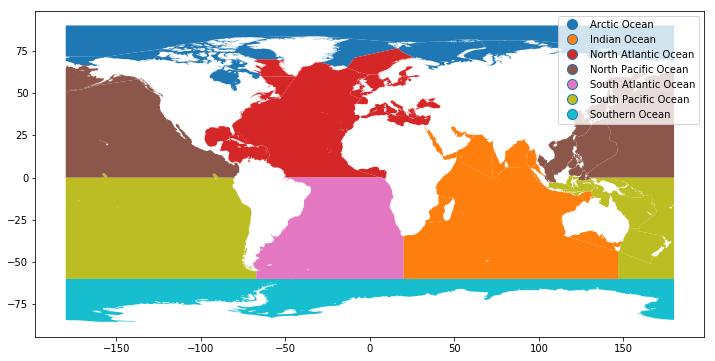

In [83]:
seas.plot(column='oceans', categorical=True, legend=True, figsize=(14, 6));

**_NOTE/COOL:_**  
See http://darribas.org/gds17/labs/Lab_02.html for great examples of lots of other cool GeoPandas map plotting tips.

Combine what we've learned. A map overlay, using `world` as a background layer, and filtering `seas` based on an attribute value (from `oceans` column) and an auto-derived GeoPandas geometry attribute (`area`). **`world` is in gray, while the filtered `seas` is in color.**

In [96]:
# Filtering
seas_na_arealt1000 = seas[(seas['oceans'] == 'North Atlantic Ocean') 
                          & (seas.geometry.area < 1000)]

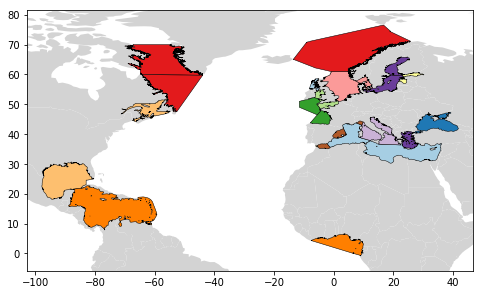

In [97]:
seas_na_arealt1000.plot(ax=world.plot(facecolor='lightgray', figsize=(8, 8)), 
                        cmap='Paired', edgecolor='black', linewidth=0.5)

# Use the bounds geometry attribute to set a nice
# geographical extent for the plot, based on the filtered GeoDataFrame
bounds = seas_na_arealt1000.geometry.bounds

plt.xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
plt.ylim([bounds.miny.min()-5, bounds.maxy.max()+5]);

### Save the filtered seas GeoDataFrame to a shape file
The `to_file` method uses the [fiona](http://toblerity.org/fiona/README.html) package to write to a GIS file. The default `driver` for output file format is 'ESRI Shapefile', but many others are available because `fiona` leverages [GDAL/OGR](http://www.gdal.org).

In [98]:
seas_na_arealt1000.to_file(os.path.join(data_pth, "seas_na_arealt1000.shp"))

### Read from OGC WFS GeoJSON response into a GeoDataFrame
Use an [Open Geospatial Consortium](http://www.opengeospatial.org) (OGC) [Web Feature Service](https://en.wikipedia.org/wiki/Web_Feature_Service) (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

We won't go into all details about what's going on. Suffice it to say that we issue an OGC WFS request for all features from the layer named "oa:goainv" found in a [GeoServer](http://geoserver.org) instance from [NANOOS](http://nanoos.org), requesting the response in `GeoJSON` format. Then we use the [geojson](https://github.com/frewsxcv/python-geojson) package to "load" the raw response (a GeoJSON string) into a `geojson` feature object (a dictionary-like object).

The "oa:goainv" layer is a global dataset of monitoring sites and cruises where data relevant to ocean acidification are collected. It's a work in progress from the [Global Ocean Acidification Observation Network (GOA-ON)](http://www.goa-on.org); for additional information see the [GOA-ON Data Portal](http://portal.goa-on.org).

In [99]:
import requests
import geojson

wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

Let's examine the general characteristics of this GeoJSON object, including its `__geo_interface__` interface, which we discussed earlier.

In [101]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
572


Now use the `from_features` constructor method to create a GeoDataFrame directly from the  `geojson.feature.FeatureCollection` object.

In [102]:
wfs_gdf = GeoDataFrame.from_features(wfs_geo)

Finally, let's visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

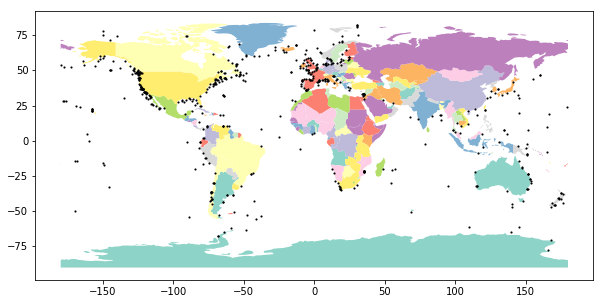

In [112]:
wfs_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
             marker='.', color='k', markersize=5);

In [113]:
# Contents of our GeoDataFrame
wfs_gdf.iloc[-1]

Oceans                                                            Indian Ocean
additional_organizations                                                      
agency                                                                        
city                                                                          
comments                                                                      
comments_about_overlaps                                                       
contact_email                                                                 
contact_name                              http://www.go-ship.org/Contacts.html
country                                                                       
data_url                            https://cchdo.ucsd.edu/cruise/33RO20180423
department                                                                    
deploy_date                                                                   
depth_range                                         

**_NOTE/FUN:_**  
Let's stop for a bit to explore on your own, hack with your neighbors, ask questions. Then we'll transition to the next notebook, on more advanced topics.